### 2023.11.23 - Introduction to Transformers Continued | Homework 3
Proximal Policy Optimization (PPO) is a type of policy gradient method for reinforcement learning that was used in the final training stage of GPT. In this homework, you will implement a highly simplified version of the PPO algorithm to get a foundational understanding of its mechanics. The aim is to outline the whole concept with mostly static components, to give you a birds eye view of how it works.

The endresult is a model that learned that the reward model prefers positive words over negative ones.

We know that there is quite a long path between this excercise and the real world application of PPO. However, since this is an introductory lecture and due to the vast diversity of the audience we will noo go into more depth.
In case you are interested in diving deeper into the realm of reinforcement learning and PPO, checkout the following resources:
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)
- [Lilian Weng Policy Gradient Algorithms](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)
- [Proximal Policy Optimization (PPO): The Key to LLM Alignment](https://cameronrwolfe.substack.com/p/proximal-policy-optimization-ppo)

Base your code on the following skeleton code that we provide.

We tried to explain our simplifications as much as possible, to help you on the one hand understand the high level concept and on the other are able to connect it to real world implementation details.

In [1]:
!/opt/conda/envs/pytorch/bin/python -m pip install matplotlib
!/opt/conda/envs/pytorch/bin/python -m pip install scipy

  Using cached matplotlib-3.8.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.45.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (155 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached contourpy-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (313 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.45.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [132]:
import torch
from torch import nn, optim
import random
import matplotlib.pyplot as plt
from scipy.signal import medfilt

In [133]:
# Import any additional dependencies
# In case you don't need any, just remove the error raise below
# YOUR CODE HERE
# raise NotImplementedError()
import torch.nn.functional as F

##### Agent and Policy:
In RLHF for LLMs, the agent is the pre-trained language model itself. The policy is represented by the model's forward function. In our case instead of using a full language model we will use a simple Multilayer perceptron (MLP) that in the end should predict positive words more likeyl than negative words, independently of the input.

In [134]:
# Define the list of words and their corresponding "positivity" score
word_scores = {"happy": 1, "joyful": 1, "pleasant": 1, "sad": -1, "angry": -1, "unpleasant": -1}
words = list(word_scores.keys())
positive_words = set({k:v for k,v in word_scores.items() if v == 1}.keys())

In [135]:
class Agent(nn.Module):
    """
    The Agent class represents a simplified version of a policy model used in Proximal Policy Optimization (PPO) that operates as
    a basic language model. The model is a Multilayer Perceptron (MLP) designed to predict the likelihood of positive words
    over negative ones, regardless of the input.

    Example:
        # Example instantiation and forward pass
        agent = Agent(num_words)
        input_data = torch.tensor([...])  # Some one-hot encoded input data
        output = agent(input_data)
    """
    # A simple MLP with 2 linear layers and a ReLU activation in between
    def __init__(self, num_words):
        super(Agent, self).__init__()
        """
        TODO: Define the architecture of the MLP: Decide on the number of layers, units in each layer, and activation functions.
        Hint: You can start as simple as 2 linear layers of low dimension (e.g. 128) with a simple ReLU activation function in between. (nn.Linear, torch.relu)
        """
        # YOUR CODE HERE
        # raise NotImplementedError()

        self.fc1 = nn.Linear(num_words, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc6 = nn.Linear(8, num_words)

    def forward(self, x):
        """
        TODO: Implement the forward pass: Define how the input data flows through the network to produce output.
        The output should be a probability distribution over words. (Hint: you might want to use torch.softmax for that)
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        
        return F.softmax(x, dim=-1)

##### Value Function/Critic/Reward Model
The critic is a separate model or mechanism that evaluates the quality of the outputs generated by the agent.
In the context of RLHF, this could be a model trained to predict human preferences or judgments regarding the quality or appropriateness of the model's responses.

In our case we just return the predefined positivy score for a given word.

In [136]:
class Critic:
    """
    A simple static model that simply uses our word_score lookup table to "judge" a given input.
    In real scenarios, critics can be complex models trained to evaluate text based on various criteria like coherence, grammar,
    and alignment with human preferences.
    """
    def __init__(self):
        super(Critic, self).__init__()

    def forward(self, word):
        return torch.tensor([word_scores.get(word, 0)])

    def __call__(self, input):
        return self.forward(input)

##### Baseline

The primary purpose of using a baseline is to reduce the variance of the gradient estimate without biasing it. In policy gradient methods, the goal is to maximize the expected reward. However, the gradient of this expectation can have high variance, leading to inefficient learning. By subtracting a baseline from the reward, the variance of the gradient can be significantly reduced, which typically results in more stable and efficient learning.

In [137]:
class Baseline:
    """
    The Baseline class in this exercise represents a mechanism to calculate and update a baseline value used 
    in the Proximal Policy Optimization (PPO) algorithm. The baseline is utilized to reduce the variance in the
    policy gradient estimation, leading to more stable and efficient learning.

    In this exercise, you will implement and use the Baseline class to compute an average score.
    
    Example:
        # Example of updating and getting the baseline
        baseline = Baseline()
        baseline.update(new_score=1.0)
        current_baseline = baseline.get()
    """
    def __init__(self):
        self.total_score = 0.0
        self.count = 0

    def update(self, new_score):
        # TODO: Implement the update method: Update the total score and count based on the new score received after each action.
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.total_score += new_score
        self.count += 1
        
    def get(self):
        # TODO: Implement the get method: Calculate and return the current average score (baseline).
        # YOUR CODE HERE
        # raise NotImplementedError()
        return(self.total_score/max(1, self.count))

##### Training Loop

In [138]:
def train(agent, critic, optim, epsilon=0.01, iter=100):
    """
    This function represents the training loop where the Proximal Policy Optimization (PPO) algorithm is applied
    to train the Agent. The function takes the agent, critic, and optimizer as inputs and performs iterative training.

    The loop involves selecting actions (words), evaluating them, and updating the agent's policy based on the calculated loss.


    Parameters:
        agent (Agent): The policy model (MLP) being trained.
        critic (Critic): The model used to evaluate the quality of actions.
        optimizer (torch.optim): The optimizer used for updating the agent.
        epsilon (float): The probability of choosing a random action (exploration).
        iter (int): The number of training iterations.

    Returns:
        tuple: A tuple containing the loss and positive word count metrics over training iterations.

    Example:
        # Example training call
        agent = Agent(len(words))
        critic = Critic()
        optimizer = optim.Adam(agent.parameters(), lr=3e-4)
        losses, positive_word_counts = train(agent, critic, optimizer)
    """
    
    # Training Metrics
    losses = []
    positive_word_counts = []
    total_positive_words = 0

    onehot_encorder = torch.eye(len(words))
    
    for i in range(iter):
        # In our case our "environment" is just the random selection of a word
        random_idx = random.randint(0, len(words) - 1)
        input = onehot_encorder[random_idx]

        agent_output = agent(input)   

        # TODO: Implement the logic for choosing actions based on exploration or exploitation.
        # Hint: You might want to decide between choosing a random word_index as a suggestions vs using something like torch.agrmax
        # on the agents output. (e.g. if random.random() < epsilon: choose random word else choose based on probability distribution
        
        # Important this section should assign a value to the var "word_index"
        # YOUR CODE HERE
        # raise NotImplementedError()
        if random.random() < epsilon:
            word_index = random.randint(0, len(words) - 1)
        else:
            word_index = torch.argmax(agent_output).item()


        chosen_word = words[word_index] # chosen word (=the suggested action)

        # TODO: calculate the critic_score score
        # YOUR CODE HERE
        # raise NotImplementedError()
        critic_score = critic(chosen_word)

        # TODO: update the baseline using the critic_score
        # YOUR CODE HERE
        baseline.update(critic_score.item())

        # TODO: calculate the advantage as the difference between the critic_score and the baseline
        # YOUR CODE HERE
        advantage = critic_score - baseline.get()

        # TODO: Calculate loss as the negative log of the probability of the chosen_word multiplied by the advantage
        # YOUR CODE HERE
        loss = -torch.log(agent_output[word_index]) * advantage

        
        # Update the agent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Record and compute moving average of the loss
        losses.append(loss.item())
        
        if chosen_word in positive_words:
            total_positive_words += 1
        positive_word_counts.append(total_positive_words / (i + 1))
    
        if i % 1 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}, Generated Word: {chosen_word}")

    return losses, positive_word_counts

#### Run Exercise 1
Run this cell to evaluate your implementation.

In [145]:
"""
Expected Outcome:
Iteration 0, Loss: 0.0, Generated Word: angry
Iteration 1, Loss: 2.910965919494629, Generated Word: pleasant
...
Note: The losses as well as the generated word will obviously be different.
However you should see that the number of positive words is increasing over time.

!! Important !! : With low model complexity and random weights initalizaion the model might get stuck
and produce a constant result with 0 loss. Just rerun this cell.
"""
agent = Agent(len(words))
critic = Critic()

baseline = Baseline()
optimizer = optim.Adam(agent.parameters(), lr=3e-4)

losses, positive_word_counts = train(agent, critic, optimizer)

Iteration 0, Loss: 0.0, Generated Word: pleasant
Iteration 1, Loss: 0.0, Generated Word: pleasant
Iteration 2, Loss: 0.0, Generated Word: pleasant
Iteration 3, Loss: 0.0, Generated Word: pleasant
Iteration 4, Loss: 0.0, Generated Word: pleasant
Iteration 5, Loss: 0.0, Generated Word: pleasant
Iteration 6, Loss: 0.0, Generated Word: pleasant
Iteration 7, Loss: 0.0, Generated Word: pleasant
Iteration 8, Loss: 0.0, Generated Word: pleasant
Iteration 9, Loss: 0.0, Generated Word: pleasant
Iteration 10, Loss: 0.0, Generated Word: pleasant
Iteration 11, Loss: 0.0, Generated Word: pleasant
Iteration 12, Loss: 0.0, Generated Word: pleasant
Iteration 13, Loss: 0.0, Generated Word: pleasant
Iteration 14, Loss: 0.0, Generated Word: pleasant
Iteration 15, Loss: 0.0, Generated Word: pleasant
Iteration 16, Loss: 0.0, Generated Word: pleasant
Iteration 17, Loss: 0.0, Generated Word: pleasant
Iteration 18, Loss: 0.0, Generated Word: pleasant
Iteration 19, Loss: 0.0, Generated Word: pleasant
Iteration 

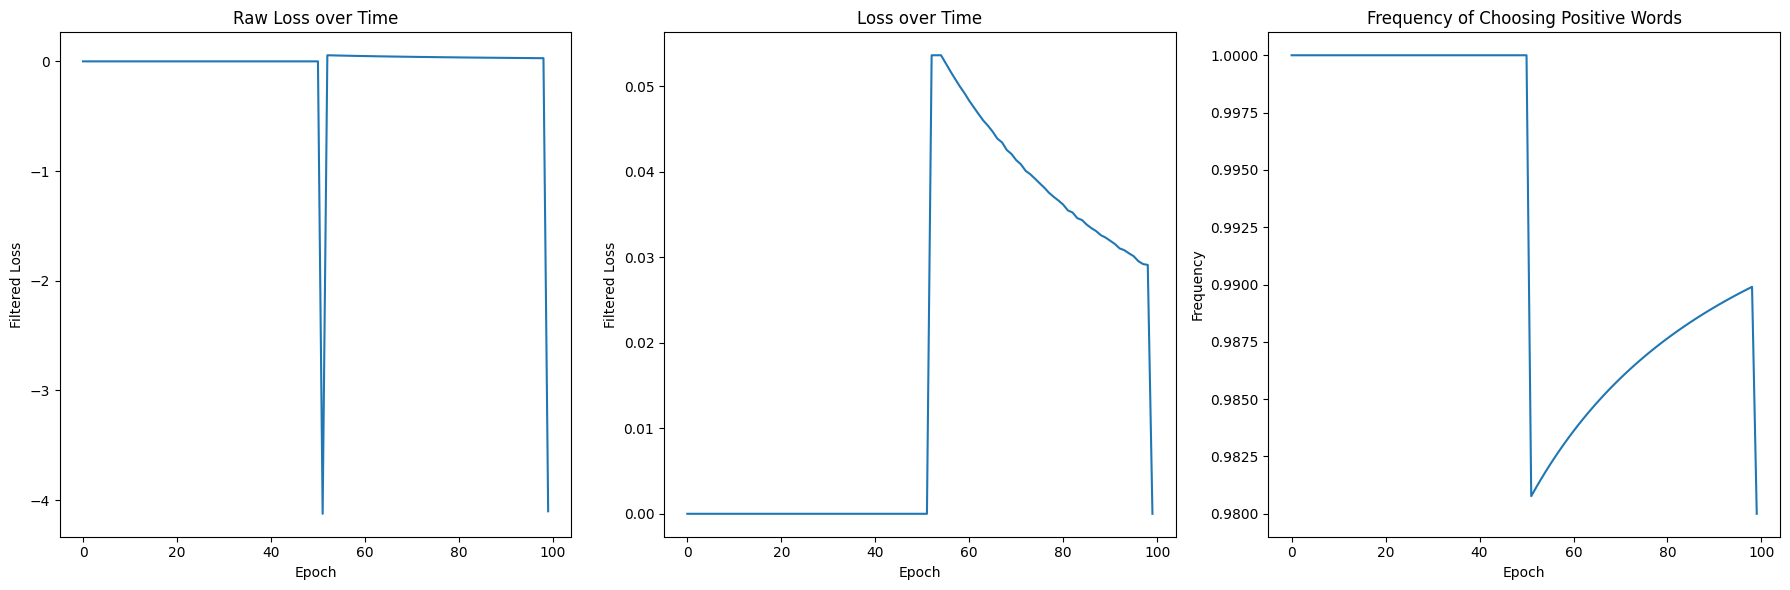

In [146]:
"""
Expected Outcome:
You should see 3 figures, the first two should show a declining slop, the third one should look more like a log function.
"""
filtered_loss = medfilt(losses, kernel_size=5)

# Plot the filtered loss
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Raw Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Filtered Loss")

plt.subplot(1, 3, 2)
plt.plot(filtered_loss)
plt.title("Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Filtered Loss")

# Plotting the frequency of choosing positive words
plt.subplot(1, 3, 3)
plt.plot(positive_word_counts)
plt.title("Frequency of Choosing Positive Words")
plt.xlabel("Epoch")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()